In [28]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import text


### Importing Dataset

In [12]:
df = pd.read_csv('reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Preprocessing (vectorizer, padding, train-test split)

In [13]:
# Convert Score to binary sentiment: 1-2 stars as negative (0), 4-5 stars as positive (1)
df['sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0 if x <= 2 else None)

# Drop rows with neutral scores (3)
df = df.dropna(subset=['sentiment'])

# Extract reviews and labels
reviews = df['Text'].values
labels = df['sentiment'].values

# Tokenize the reviews
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Pad sequences
max_length = 100
X = pad_sequences(sequences, maxlen=max_length)

# Convert labels to numpy array
y = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Building the Model's Architecture

In [14]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()

/Users/mohammed/miniconda3/envs/MLenv2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training the Model

In [15]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
6573/6573 ━━━━━━━━━━━━━━━━━━━━ 1055s 160ms/step - accuracy: 0.9074 - loss: 0.2372 - val_accuracy: 0.9425 - val_loss: 0.1473
Epoch 2/5
6573/6573 ━━━━━━━━━━━━━━━━━━━━ 1310s 199ms/step - accuracy: 0.9499 - loss: 0.1323 - val_accuracy: 0.9575 - val_loss: 0.1150
Epoch 3/5
6573/6573 ━━━━━━━━━━━━━━━━━━━━ 1008s 153ms/step - accuracy: 0.9600 - loss: 0.1077 - val_accuracy: 0.9609 - val_loss: 0.1061
Epoch 4/5
6573/6573 ━━━━━━━━━━━━━━━━━━━━ 1014s 154ms/step - accuracy: 0.9659 - loss: 0.0932 - val_accuracy: 0.9626 - val_loss: 0.1025
Epoch 5/5
6573/6573 ━━━━━━━━━━━━━━━━━━━━ 1029s 157ms/step - accuracy: 0.9688 - loss: 0.0841 - val_accuracy: 0.9646 - val_loss: 0.0999


### Evaluating the model 

1644/1644 ━━━━━━━━━━━━━━━━━━━━ 103s 63ms/step - accuracy: 0.9652 - loss: 0.0996
Test score: 0.09986867010593414
Test accuracy: 0.9646168351173401


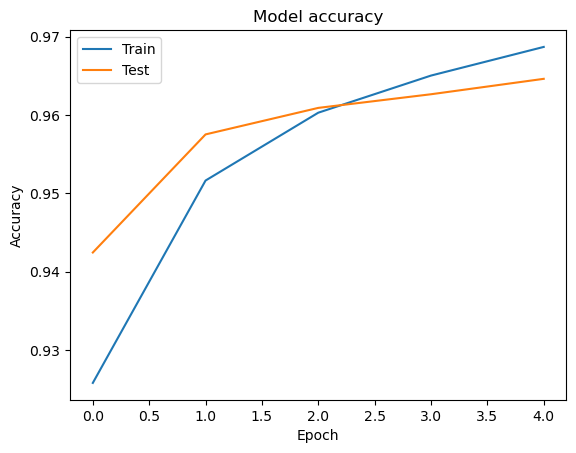

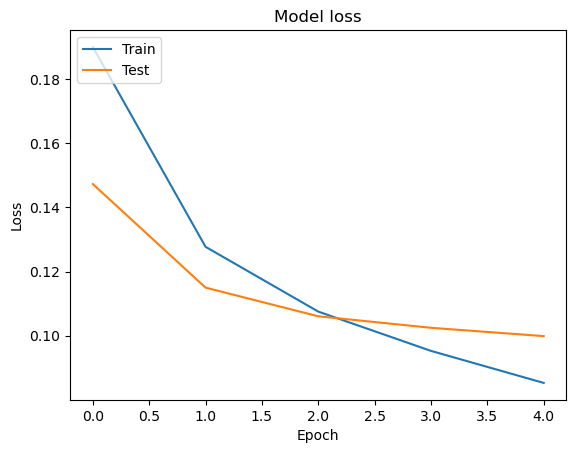

In [16]:
# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'Test score: {score}')
print(f'Test accuracy: {acc}')

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Predictive Model

In [19]:
# Predict sentiment for new reviews
new_reviews = ["This product is great!", "I didn't like this item."]
sequences = tokenizer.texts_to_sequences(new_reviews)
padded_sequences = pad_sequences(sequences, maxlen=max_length)
predictions = model.predict(padded_sequences)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype("int32")

# Map binary labels to human-readable text
label_map = {0: 'Negative', 1: 'Positive'}
predicted_text_labels = [label_map[label[0]] for label in predicted_labels]

# Print the results
for review, pred_text in zip(new_reviews, predicted_text_labels):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {pred_text}")
    print()

print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Review: This product is great!
Predicted Sentiment: Positive

Review: I didn't like this item.
Predicted Sentiment: Negative

[[0.9979496 ]
 [0.03458677]]


### Persisting the Model and Tokenizer

In [20]:
model.save('sentiment_analysis_model.h5')

In [23]:
import pickle


with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
